In [1]:
import pandas as pd
import numpy as np
from typing import List

In [2]:
adj = pd.read_csv('adj.txt', header=None)
# make adj matrix
adj_matrix = np.zeros((len(adj),len(adj)))
for i in range(len(adj)):
    for j in range(len(adj)):
        if i == j:
            continue
        if str(j) in adj.iloc[i,0].split(' '):
            adj_matrix[i,j] = 1
            adj_matrix[j,i] = 1
# label            
label = np.loadtxt('karate_label.txt')

In [204]:
class Node:
    def __init__(self,value):
        self.value = value
        self.left = None
        self.right = None
        
class BinaryTree:
    def __init__(self,head):
        self.head = head
        self.left= None
        self.right= None
    
    def insert(self,key):
        self.current_node = self.head
        
        while True:
            if key < self.current_node.value:
                if self.current_node.left != None:
                    self.current_node = self.current_node.left
                else :
                    self.current_node.left = Node(key)
                    break
            else :
                if self.current_node.right !=None:
                    self.current_node = self.current_node.right
                else :
                    self.current_node.right = Node(key)
                    break
    
    def path(self,key):        
        self.current_node = self.head
        path_list = []
        way_list = []
        while key>1:
            if key%2 ==0:
                path_list.append(int(key/2))
                way_list.append(1)
            else :
                path_list.append(int((key-1)/2))
                way_list.append(-1)
            key = int(key/2)
        return np.flip(path_list), np.flip(way_list)

In [221]:
vec = []
start = np.random.rand(2)
vec.append(start)
head = Node(0)
h_Softmax_tree = BinaryTree(head)

V = 34
for key in range(1,2*34-1):
    tree_node = np.random.rand(2)
    vec.append(tree_node)
    h_Softmax_tree.insert(key)

In [222]:
path, left_right = h_Softmax_tree.path(5)

In [223]:
path

array([1, 2])

In [224]:
left_right

array([ 1, -1])

In [225]:
vec[:3]

[array([0.59197586, 0.6880471 ]),
 array([0.8032963 , 0.09503118]),
 array([0.96913092, 0.52184231])]

In [340]:
class DeepWalk:
    def __init__(self,
                 adj_matrix,
                 embedding_dim=2,
                 walks_per_vertex=5,
                 walk_len=10,
                 window_size=3,
                 learning_rate=0.02):
        
        self.adj_matrix = adj_matrix
        self.embedding_dim = embedding_dim
        self.walks_per_vertex = walks_per_vertex
        self.walk_len = walk_len
        self.window_size = window_size
        self.learning_rate = learning_rate
        
        self.w1 = np.random.rand(len(adj_matrix),embedding_dim)
        
        self.loss = 0.0
        self.epoch_loss = []
        self.epoch_loss_de = len(self.adj_matrix)
    
        # randomly initialize
        # make binary tree
        self.vec = []
        start = np.random.rand(embedding_dim)
        vec.append(start)
        head = Node(0)
        self.h_softmax_tree = BinaryTree(head)

        V = len(adj_matrix)
        for key in range(1,2*V-1):
            tree_node = np.random.rand(embedding_dim)
            self.vec.append(tree_node)
            self.h_softmax_tree.insert(key)
    
    def _sigmoid(x):
        return 1/(1+np.exp(-x))
    
    def _random_walk(self, start_node: int)-> List:
        walk = [0] * self.walk_len
        walk[0] = start_node
        node = start_node
        for i in range(1, self.walk_len):
            next_node = np.random.choice(np.where(self.adj_matrix[node]==1)[0])
            walk[i] = next_node
            node = next_node
        return walk

    def _skip_gram_train(self, walk: List)-> None:
        for idx, input_node in enumerate(walk):
            # make dataset
            left_idx = idx - 3
            right_idx = idx + 3
            if left_idx < 0: left_idx = 0
            if right_idx > self.walk_len-1: right_idx = self.walk_len
            left_node = walk[left_idx:idx]
            right_node = walk[idx+1:right_idx+1]
            output_nodes = left_node + right_node

            # train
            hidden = self.w1[input_node]
            for output_node in output_nodes:
                # get path
                path, left_right = self.h_softmax_tree.path(index_to_key(output_node))
                tmp = [self.vec[i] for i in path] @ hidden
                # calcuate epoch loss
                self.loss = - np.sum(np.log(sigmoid(tmp * left_right))) / self.epoch_loss_de
                # backprop, optimization
                left_right = [1 if i==1 else 0 for i in left_right] 
                EH = 0
                for i, path_val in enumerate(path):
                    tmp = sigmoid(self.vec[path_val] @ hidden) - left_right[i]
                    EH += self.vec[path_val] * tmp
                    self.vec[path_val] = self.vec[path_val] - self.learning_rate * tmp * hidden
                self.w1[input_node] = self.w1[input_node] - self.learning_rate * EH            

    def train(self)-> float:
        V = np.arange(0, len(self.adj_matrix))
        for _ in range(self.walks_per_vertex):
            # shuffle vertex
            np.random.shuffle(V)
            for start_node in V:
                # random walk
                W = self._random_walk(start_node)
                # skip-gram
                self._skip_gram_train(W)
            # consider epoch as if all node be start_node
            self.epoch_loss.append(self.loss)
            self.loss = 0.0
        return self.epoch_loss
    
    def show_embedding(self):
        return self.w1

In [392]:
model = DeepWalk(adj_matrix, walks_per_vertex=5, walk_len=10, window_size=3, learning_rate=0.02)
loss = model.train()

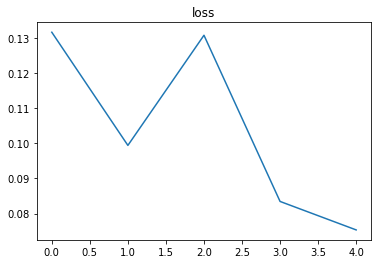

In [393]:
import matplotlib.pyplot as plt
plt.title('loss')
plt.plot(loss)

In [394]:
embedding_matrix = model.show_embedding()

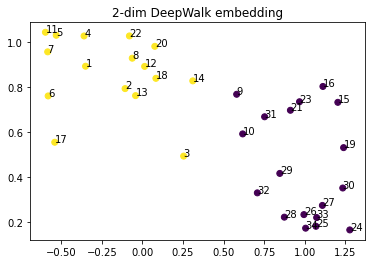

In [395]:
plt.title('2-dim DeepWalk embedding')
plt.scatter(embedding_matrix[:,0],embedding_matrix[:,1], c=list(map(int, label[:,1])))
for i in range(0, 34):
        plt.text(float(embedding_matrix[i,0]), float(embedding_matrix[i,1]), i+1 , fontsize=10)
plt.show()